<a href="https://colab.research.google.com/github/lszam/fabrizio-mars/blob/main/fab_mars_mag_saida_qgis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Editor: Luizemara Szameitat     
Ver.1 17-04-2025*

In [1]:
!pip install rasterio pyproj -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.transform import xy
from scipy.interpolate import griddata
import pandas as pd
import pyproj
from pyproj import CRS


Download dos dados magnéticos. **Altitude de 200 km nominal.**

In [3]:
!wget "https://core2.gsfc.nasa.gov/research/purucker/br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz"

--2025-04-17 18:26:21--  https://core2.gsfc.nasa.gov/research/purucker/br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz
Resolving core2.gsfc.nasa.gov (core2.gsfc.nasa.gov)... 129.164.179.114
Connecting to core2.gsfc.nasa.gov (core2.gsfc.nasa.gov)|129.164.179.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1935020 (1.8M) [chemical/x-xyz]
Saving to: ‘br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz’

br_spoabgt3_mars_rd 100%[===================>]   1.84M  1.20MB/s    in 1.5s    

2025-04-17 18:26:23 (1.20 MB/s) - ‘br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz’ saved [1935020/1935020]



In [4]:
# Carregar e verificar o arquivo mag
file_path = 'br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[:10]

['   -180.00    -88.00     26.09\n',
 '   -180.00    -87.00     45.55\n',
 '   -180.00    -86.00     53.78\n',
 '   -180.00    -85.00     57.34\n',
 '   -180.00    -84.00     76.63\n',
 '   -180.00    -83.00     96.04\n',
 '   -180.00    -82.00     90.78\n',
 '   -180.00    -81.00     49.83\n',
 '   -180.00    -80.00    -22.64\n',
 '   -180.00    -79.00   -111.42\n']

In [5]:
# Carregar os dados como um DataFrame para melhor controle
data_df = pd.read_csv(file_path, sep='\s+', header=None) #delim_whitespace=True vai ser descontinuado

# Exibir as primeiras linhas do DataFrame para verificar a estrutura
data_df.head()

,0,1,2
0,-180.0,-88.0,26.09
1,-180.0,-87.0,45.55
2,-180.0,-86.0,53.78
3,-180.0,-85.0,57.34
4,-180.0,-84.0,76.63


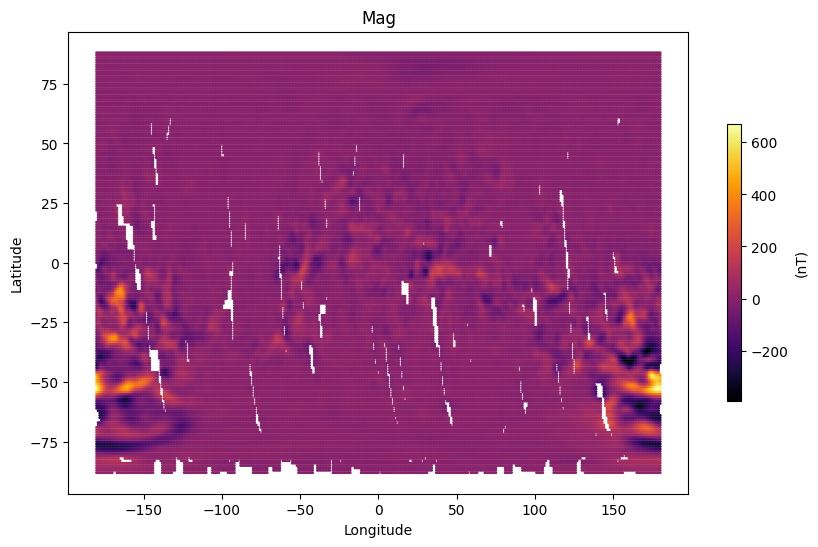

In [6]:
# Extrair dados das colunas e plotar como pontos para ver a distribuição
latitudes = data_df[1].values
longitudes = data_df[0].values
mag = data_df[2].values

plt.figure(figsize=(10, 6))
plt.scatter(longitudes, latitudes, c=mag, cmap='inferno', s=1)
plt.colorbar(label='(nT)', shrink=0.6)
plt.title('Mag')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


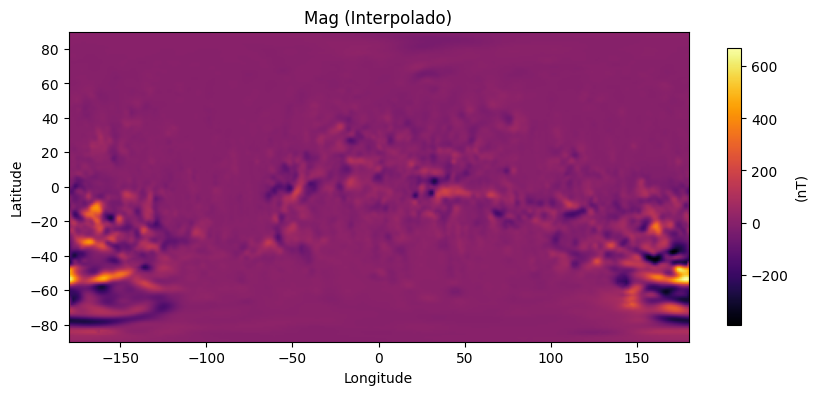

('mars_mag_interpolado.tif', 'mars_mag_data.csv')

In [7]:
# Definir a resolução e o número de células da grade
lat_range = (latitudes.min(), latitudes.max())
lon_range = (longitudes.min(), longitudes.max())
n_rows = len(np.unique(latitudes))
n_cols = len(np.unique(longitudes))

# Calcular a resolução dos pixels
resolution_lat = (latitudes.max() - latitudes.min()) / len(np.unique(latitudes))
resolution_lon = (longitudes.max() - longitudes.min()) / len(np.unique(longitudes))

# Criar uma grade regular
# Trocar latitudes e longitudes nas variáveis meshgrid para corrigir o giro
lon_grid_regular, lat_grid_regular = np.meshgrid(np.linspace(longitudes.min(), longitudes.max(), n_cols), np.linspace(latitudes.min(), latitudes.max(), n_rows))


# Interpolar os valores do mag
mag_grid_regular = griddata((latitudes, longitudes), mag, (lat_grid_regular, lon_grid_regular), method='linear')

# Plot
extent = [-180, 180, -90, 90]
plt.figure(figsize=(10, 6))
plt.imshow(mag_grid_regular, cmap='inferno', extent=extent, origin='lower')
plt.colorbar(label='(nT)', shrink=0.6)
plt.title('Mag (Interpolado)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Transformação geográfica
transform = from_origin(lon_range[0], lat_range[1], resolution_lon, resolution_lat)

# Salvar GeoTIFF
geotiff_path = 'mars_mag_interpolado.tif'
with rasterio.open(geotiff_path, 'w', driver='GTiff', height=n_rows, width=n_cols, count=1, dtype='float64', crs='EPSG:4326', transform=transform) as dst:
    dst.write(mag_grid_regular, 1)

# Salvar CSV
csv_path = 'mars_mag_data.csv'
data_df.to_csv(csv_path, index=False, header=False)

geotiff_path, csv_path




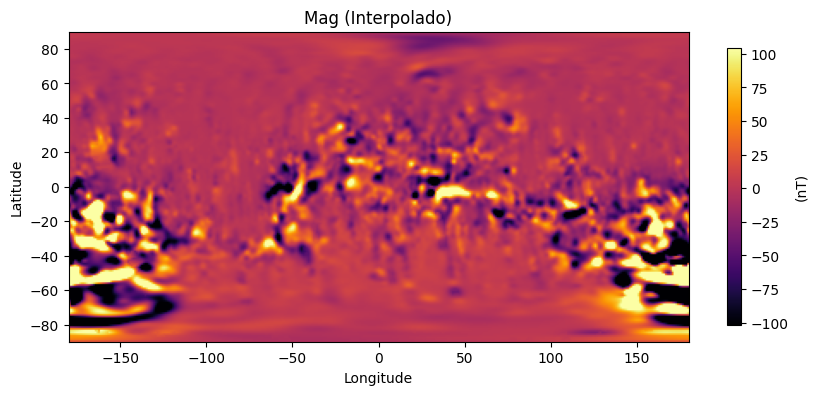

In [8]:
# Com normalização de contraste
extent = [-180, 180, -90, 90]
vmin, vmax = np.nanpercentile(mag, [2, 98])

plt.figure(figsize=(10, 6))
plt.imshow(mag_grid_regular, cmap='inferno', extent=extent, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(label='(nT)', shrink=0.6)
plt.title('Mag (Interpolado)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Mudar CRS para um sistema projetado

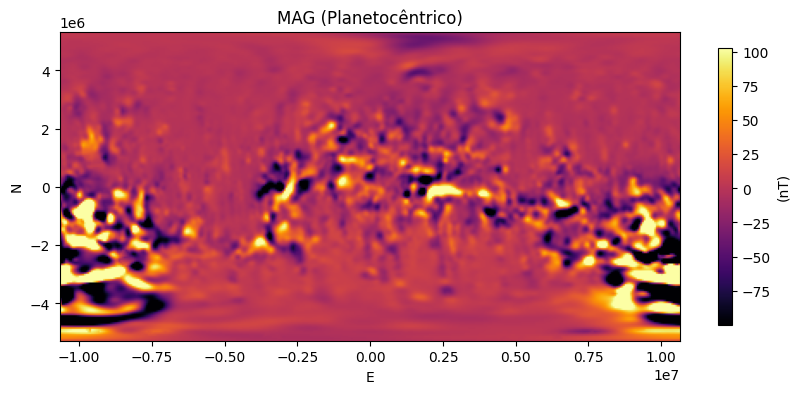

GeoTIFF salvo: mars_mag_interpolado_proj.tif


In [22]:
from rasterio.transform import array_bounds

# Abrir o arquivo GeoTIFF
with rasterio.open('mars_mag_interpolado.tif') as src:
    # Obter o número de linhas e colunas
    LINES, COLS = src.shape
    # Obter os dados de entrada
    data = src.read(1)
    # Obter o CRS de origem
    src_crs = src.crs
    # Obter a transformação de origem
    src_transform = src.transform

# Definir limites e transformação geográfica de origem (planetocêntrico)
bounds = (-180.0, -90.0, 180.0, 90.0)  # (left, bottom, right, top)
src_transform = from_bounds(*bounds, width=COLS, height=LINES)

# Definir CRS de origem e destino usando elipsoide IAU Mars2000
# Raios de Marte
a = 3396190.0
b = 3376200.0
src_crs = CRS.from_proj4(f"+proj=longlat +a={a} +b={b} +no_defs")
dst_crs = CRS.from_proj4(
    f"+proj=eqc +lat_ts=0 +lon_0=0 +a={a} +b={b} +units=m +no_defs"
)

# Calcular a transformação e as dimensões para o CRS planetocêntrico projetado
dst_transform, dst_width, dst_height = calculate_default_transform(
    src_crs, dst_crs, COLS, LINES, *bounds
)

# Matriz
dst_array = np.empty((dst_height, dst_width), dtype=data.dtype)

# Reprojetar
reproject(
    source=data,
    destination=dst_array,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear
)

# Plot
left, bottom, right, top = array_bounds(dst_height, dst_width, dst_transform)
extent = [left, right, bottom, top]
vmin, vmax = np.nanpercentile(dst_array, [2, 98])

plt.figure(figsize=(10, 6))
plt.imshow(dst_array, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax, extent=extent)
plt.title('MAG (Planetocêntrico)')
plt.xlabel('E')
plt.ylabel('N')
plt.colorbar(label='(nT)', shrink=0.6)
plt.show()

# Salvar o arquivo GeoTIFF reprojetado
output_tif = 'mars_mag_interpolado_proj.tif'
with rasterio.open(
    output_tif, 'w',
    driver='GTiff',
    height=dst_height,
    width=dst_width,
    count=1,
    dtype=dst_array.dtype,
    crs=dst_crs,
    transform=dst_transform
) as dst:
    dst.write(dst_array, 1)

print(f"GeoTIFF salvo: {output_tif}")

In [27]:
# Salvar um csv do geotiff do mag interpolado e projetado

with rasterio.open('mars_mag_interpolado_proj.tif') as src:
    data = src.read(1)
    transform = src.transform

rows, cols = data.shape
data_list = []

# Itera sobre cada pixel
for row in range(rows):
    for col in range(cols):
        # obtém X e Y no CRS projetado
        x_proj, y_proj = xy(transform, row, col)
        mag = data[row, col]
        data_list.append([x_proj, y_proj, mag])

df = pd.DataFrame(data_list, columns=["X", "Y", "MAG"])
df.to_csv('mars_mag_interpolado_proj.csv', index=False)
print("GeoTIFF salvo: mars_mag_interpolado_proj.csv")

GeoTIFF salvo: mars_mag_interpolado_proj.csv


In [28]:
from google.colab import files
import glob

for file in glob.glob("*.tif") + glob.glob("*.csv") + glob.glob("*.xyz"):
  files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>